# 猫狗大战 训练模型

在此项目中，将对 [kaggle dogs vs. cats 数据集](https://www.kaggle.com/c/5441/download-all) 中的图片进行分类。该数据集主要包含猫狗和若干异常图片。项目需要预处理这些图片，然后基于预训练模型导出特征向量，构建一个新的模型的，用特征向量为输入进行训练。最后，由新模型对测试集的图片作出是猫还是狗的预测。


## 导出特征向量

从keras的预训练模型Xception中，导出特征向量。


In [4]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import os

import h5py


dataset_folder_path = os.getcwd() + '/data'
train_dataset_folder_path = dataset_folder_path + '/train'
test_dataset_folder_path = dataset_folder_path + '/test'


image_size = (299, 299)
input_tensor = Input((image_size[0], image_size[1], 3))
x = input_tensor
x = Lambda(xception.preprocess_input)(x)
    
base_model = Xception(include_top=False, weights='imagenet', input_tensor=x)
model = Xception(input_tensor=base_model.input, pooling=GlobalAveragePooling2D()(base_model.output))

gen = ImageDataGenerator()
train_generator = gen.flow_from_directory(train_dataset_folder_path, image_size, shuffle=False, 
                                          batch_size=16)
test_generator = gen.flow_from_directory(test_dataset_folder_path, image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

X_train = model.predict_generator(train_generator)
X_test = model.predict_generator(test_generator)

with h5py.File('Xception.h5') as fp:
        fp.create_dataset('train', data = X_train)
        fp.create_dataset('test', data = X_test)
        fp.create_dataset('label', data = train_generator.classes)

print("export features finished.")

Found 24953 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
export features finished.


### 导入特征向量

运行上面的代码后，将生成1个特征向量文件：

 * Xception.h5

载入这些特征向量，然后对 X 和 y 重新随机排序，随机种子固定为42，为了可以复现结果。


In [5]:
import h5py
import numpy as np
from sklearn.utils import shuffle

X_train = []
X_test = []

with h5py.File("Xception.h5", 'r') as h:
    X_train.append(np.array(h['train']))
    X_test.append(np.array(h['test']))
    y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train, random_state=42)


## 构建并编译模型

添加dropout层，然后分类。


In [22]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])

x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

myModel = Model(input_tensor, Dropout(0.3)(input_tensor))
myModel = Model(myModel.input, Dense(1, activation = 'sigmoid')(myModel.output))

myModel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 训练模型

设置验证集大小为 10% ，也就是说训练集是22458张图，验证集是2495张图。


In [23]:
train_history = myModel.fit(X_train, y_train, batch_size=128, epochs=8, validation_split=0.2)

Train on 19962 samples, validate on 4991 samples
Epoch 1/8
19962/19962 [==============================] - 3s 130us/step - loss: 0.6914 - acc: 0.5198 - val_loss: 0.6898 - val_acc: 0.5518
Epoch 2/8
19962/19962 [==============================] - 1s 31us/step - loss: 0.6882 - acc: 0.5437 - val_loss: 0.6871 - val_acc: 0.5560
Epoch 3/8
19962/19962 [==============================] - 1s 30us/step - loss: 0.6860 - acc: 0.5446 - val_loss: 0.6849 - val_acc: 0.5574
Epoch 4/8
19962/19962 [==============================] - 1s 31us/step - loss: 0.6847 - acc: 0.5432 - val_loss: 0.6833 - val_acc: 0.5600
Epoch 5/8
19962/19962 [==============================] - 1s 30us/step - loss: 0.6831 - acc: 0.5475 - val_loss: 0.6820 - val_acc: 0.5586
Epoch 6/8
19962/19962 [==============================] - 1s 30us/step - loss: 0.6812 - acc: 0.5479 - val_loss: 0.6807 - val_acc: 0.5608
Epoch 7/8
19962/19962 [==============================] - 1s 30us/step - loss: 0.6815 - acc: 0.5441 - val_loss: 0.6799 - val_acc: 0.560

# 可视化学习曲线

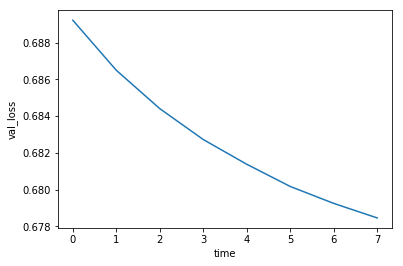

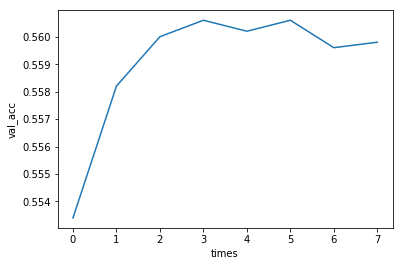

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['val_loss'])
plt.xlabel('time')
plt.ylabel('val_loss')
plt.show()

plt.plot(train_history.history['val_acc'])
plt.xlabel('times')
plt.ylabel('val_acc')
plt.show()

## 对测试数据集进行预测

预测并生成预测结果文件，用于上传kaggle。

In [24]:
import pandas as pd

y_pred = myModel.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

12500/12500 [==============================] - 1s 99us/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,id,label
0,1,0.476543
1,2,0.476543
2,3,0.476543
3,4,0.563068
4,5,0.476543
5,6,0.476543
6,7,0.476543
7,8,0.476621
8,9,0.490374
9,10,0.476543
